In [1]:
import gymnasium as gym
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from tqdm import trange


In [2]:
filename = "./blackjack_MCES_ep_100000000.pkl"

In [3]:
class OnPolicyFirstVistMCSoft():
    def __init__(self, observation_space, action_space) -> None:
        """
        Epsilon-soft Policy
        """
        state_action_shape =  [s.n for s in observation_space] + [action_space.n]

        # (player current sum, dealer showing card value, usable ace, stick/hit)
        self.action_values = np.zeros(state_action_shape)
        self.returns = np.zeros_like(self.action_values)
        self.policy = np.ones_like(self.action_values)/action_space.n
        self.state_visit_counts = np.ones_like(self.action_values)

        self.actions = [0,1]
        self.epsilon = 0.001
        self.discount = 1.


        if not np.all(self.policy.sum(-1) == 1):
            raise Exception("Probability of actions do not sum up to 1!")
        
    def sample_action(self, state):
        action = np.random.choice(self.actions, p=self.policy[state])
        return int(action)
    
    def check_already_visited(self, first_visit_list, state):
        for first_state in first_visit_list:
            elements_equal = True
            for a, b in zip(first_state, state):
                if a != b:
                    elements_equal = False
            if elements_equal == True:
                return True
        return False
    
    def get_state_values(self, state):
        return sum([self.action_values[state+(action,)]*self.policy[state+(action,)] for action in self.actions])
    
    def compute_return(self, episode, t):
        discount = 1
        g_return = 0
        for _, _, reward_t_T in episode[t:]:
            g_return += discount*reward_t_T
            discount *= self.discount

        return g_return
    
    def update_policy(self, episode):   # episode -> [(s,a,r), (s',a',r'), (s",a",r"), ...]
        # update state action values from episode
        first_visit_list = []
        for t, sar in enumerate(episode):
            state = sar[0]
            action = sar[1]
            state_action = state + (action,)
            if not self.check_already_visited(first_visit_list, state_action):  # might not work, depends if tuple can be compared
                first_visit_list.append(state_action)

                g_return = self.compute_return(episode, t)

                self.returns[state_action] = self.returns[state_action] + (1/self.state_visit_counts[state_action])*(g_return - self.returns[state_action])
                self.state_visit_counts[state_action] += 1
                self.action_values[state_action] = self.returns[state_action]

        # update policy according to new state action values
        for state, _, _ in episode:
            a_star = self.actions[np.argmax(self.action_values[state])]

            for a in self.actions:
                if a == a_star:
                    self.policy[state][a] = 1-self.epsilon+(self.epsilon/len(self.actions))
                else:
                    self.policy[state][a] = self.epsilon/len(self.actions)
        

class OnPolicyFirstVistMCES():
    def __init__(self, observation_space, action_space) -> None:
        """
        Epsilon-soft Policy
        """
        state_action_shape =  [s.n for s in observation_space] + [action_space.n]

        # (player current sum, dealer showing card value, usable ace, stick/hit)
        self.action_values = np.zeros(state_action_shape)
        self.returns = np.zeros_like(self.action_values)
        self.policy = np.ones_like(self.action_values)/action_space.n
        self.state_visit_counts = np.ones_like(self.action_values)

        self.actions = [0,1]
        self.discount = 1.


        if not np.all(self.policy.sum(-1) == 1):
            raise Exception("Probability of actions do not sum up to 1!")
        
    def sample_action(self, state):
        action = np.random.choice(self.actions, p=self.policy[state])
        return int(action)
    
    def check_already_visited(self, first_visit_list, state):
        for first_state in first_visit_list:
            elements_equal = True
            for a, b in zip(first_state, state):
                if a != b:
                    elements_equal = False
            if elements_equal == True:
                return True
        return False
    
    def get_state_values(self, state):
        return sum([self.action_values[state+(action,)]*self.policy[state+(action,)] for action in self.actions])
    
    def compute_return(self, episode, t):
        discount = 1
        g_return = 0
        for _, _, reward_t_T in episode[t:]:
            g_return += discount*reward_t_T
            discount *= self.discount

        return g_return
    
    def update_policy(self, episode):   # episode -> [(s,a,r), (s',a',r'), (s",a",r"), ...]
        # update state action values from episode
        first_visit_list = []
        for t, sar in enumerate(episode):
            state = sar[0]
            action = sar[1]
            state_action = state + (action,)
            if not self.check_already_visited(first_visit_list, state_action):  # might not work, depends if tuple can be compared
                first_visit_list.append(state_action)

                g_return = self.compute_return(episode, t)

                self.returns[state_action] = self.returns[state_action] + (1/self.state_visit_counts[state_action])*(g_return - self.returns[state_action])
                self.state_visit_counts[state_action] += 1
                self.action_values[state_action] = self.returns[state_action]

        # update policy according to new state action values
        for state, _, _ in episode:
            a_star = self.actions[np.argmax(self.action_values[state])]

            for a in self.actions:
                if a == a_star:
                    self.policy[state][a] = 1
                else:
                    self.policy[state][a] = 0


try:
    import cPickle as pickle
except ModuleNotFoundError:
    import pickle

def load_object(filename):
    with open(filename, 'rb') as inp:
        agent = pickle.load(inp)
    return agent

agent = load_object(filename)


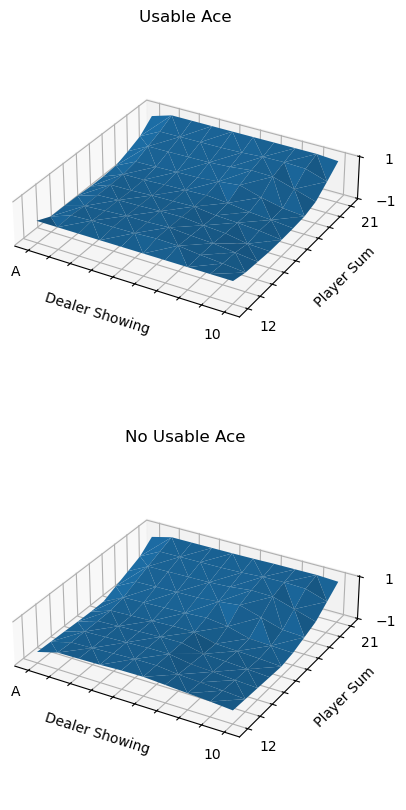

In [62]:
# Fixing random state for reproducibility
np.random.seed(19680801)
import matplotlib.gridspec as gridspec

dealer_showing = []
player_sum = []
state_value_list = []



hit_usable = np.zeros((11,10))
hit_no_usable = np.zeros((11,10))


for d in range(1,10+1):
    for p in range(11, 21+1):
        if p >= 12:
            dealer_showing.append(d)
            player_sum.append(p)
            state_value_usable = agent.get_state_values((p,d,1))

            state_value_no_usable = agent.get_state_values((p,d,0))
            state_value_list.append([state_value_no_usable, state_value_usable])

        hit_usable[(p-11,d-1)] = agent.policy[(p,d,1, 1)]
        hit_no_usable[(p-11,d-1)] = agent.policy[(p,d,0, 1)]



fig = plt.figure(figsize=(50,10))


ax = fig.add_subplot(2,1,2, projection='3d')
ax.set_title("No Usable Ace")

ax.plot_trisurf(np.array(dealer_showing), np.array(player_sum), np.array(state_value_list)[:,0])

ax.set_xlabel('Dealer Showing')
ax.set_ylabel('Player Sum')
ax.set_zlabel('Expected Return')

ax.xaxis.set_inverted(False)
ax.yaxis.set_inverted(False)

ax.set_xticks([d for d in range(1,10+1)])
ax.set_xticklabels(("A", "", "", "", "", "", "", "", "","10"))
ax.set_yticks([p for p in range(12, 21+1)])
ax.set_yticklabels(("12", "", "", "", "", "", "", "", "","21"))
ax.set_zticks([-1,1])
ax.set_zlim([-1,1])
#ax.set_zticklabels(("-1", "", "", "", "", "", "", "","1"))

ax.set_aspect('equal')

ax2 = fig.add_subplot(2,1,1, projection='3d')
ax2.set_title("Usable Ace")
ax2.plot_trisurf(np.array(dealer_showing), np.array(player_sum), np.array(state_value_list)[:,1])

ax2.set_xlabel('Dealer Showing')
ax2.set_ylabel('Player Sum')
ax2.set_zlabel('Expected Return')

ax2.xaxis.set_inverted(False)
ax2.yaxis.set_inverted(False)

ax2.set_xticks([d for d in range(1,10+1)])
ax2.set_xticklabels(("A", "", "", "", "", "", "", "", "","10"))
ax2.set_yticks([p for p in range(12, 21+1)])
ax2.set_yticklabels(("12", "", "", "", "", "", "", "", "","21"))
ax2.set_zticks([-1,1])
ax2.set_zlim([-1,1])
#ax2.set_zticklabels(("-1", "", "", "", "", "", "", "","1"))

ax2.set_aspect('equal')

#fig.subplots_adjust()
#plt.tight_layout()
plt.show()

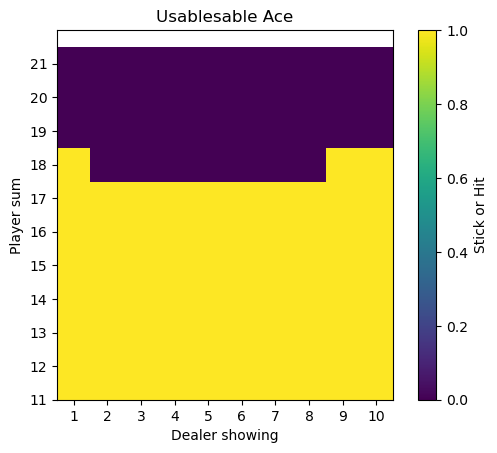

In [63]:
plt.imshow(hit_usable, interpolation='nearest')
plt.ylim([0,11])
cbar = plt.colorbar()
cbar.set_label('Stick or Hit', rotation=90)


plt.xlabel("Dealer showing")
plt.ylabel("Player sum")
plt.xticks(range(hit_usable.shape[1]), labels=range(1,hit_usable.shape[1]+1))
plt.yticks(range(hit_usable.shape[0]), labels=range(11,hit_usable.shape[0]+11))

plt.title("Usablesable Ace")

plt.show()

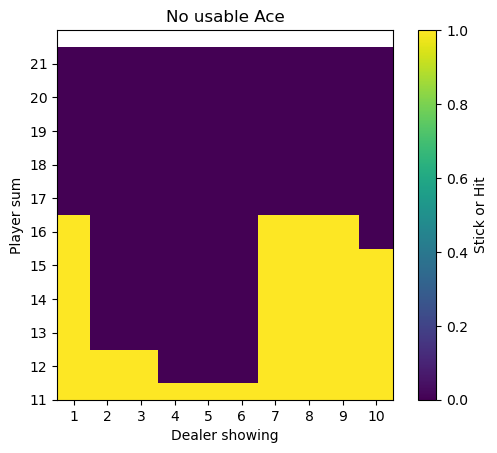

In [64]:
plt.imshow(hit_no_usable, interpolation='nearest')
plt.ylim([0,11])
cbar = plt.colorbar()
cbar.set_label('Stick or Hit', rotation=90)


plt.xlabel("Dealer showing")
plt.ylabel("Player sum")
plt.xticks(range(hit_usable.shape[1]), labels=range(1,hit_usable.shape[1]+1))
plt.yticks(range(hit_usable.shape[0]), labels=range(11,hit_usable.shape[0]+11))

plt.title("No usable Ace")

plt.show()

In [46]:
agent.policy[:12]=100

In [47]:
agent.policy

array([[[[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]],

        ...,

        [[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]]],


       [[[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]],

        ...,

        [[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]]],


       [[[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]],

        ...,

        [[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]],

        [[100. , 100. ],
         [100. , 100. ]]],


       ...,


  